<img src="http://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />
<!--- @wandbcode{intro-colab} -->

In [1]:
!pip install wandb -qU

In [2]:
import wandb

In [3]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anjaliv (anjaliv-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


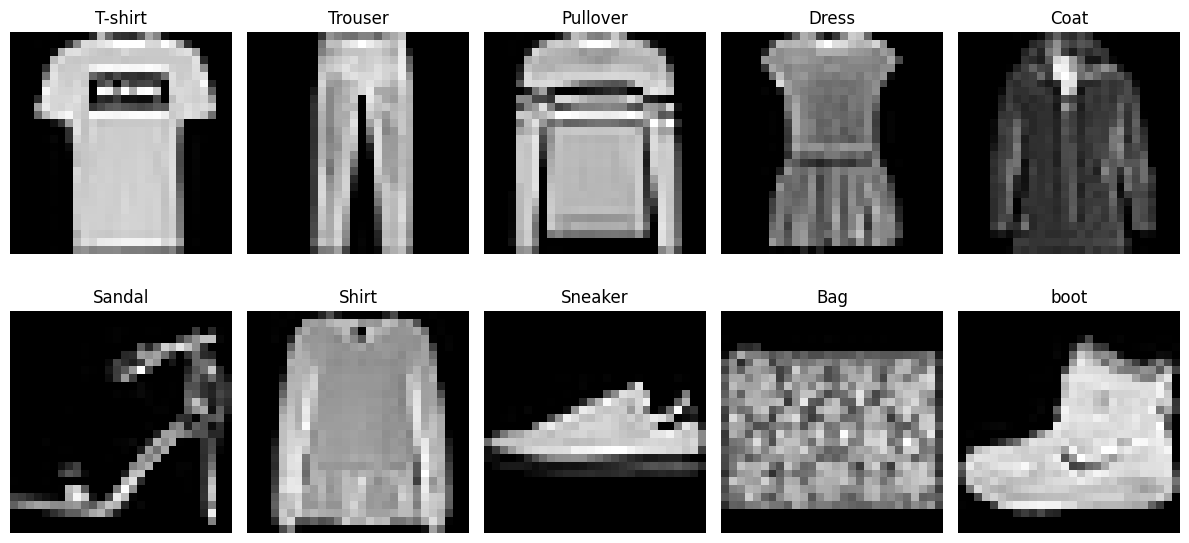

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

# Load the Fashion-MNIST dataset
(x_train, y_train), (X_test,Y_test) = fashion_mnist.load_data()

# print(x_train.shape)
# print(y_train.shape)
# print(x_train[0])
# print(y_train[0])

# Define class labels
class_labels = {
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'boot'
}

# Plot one sample image for each class
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for i in range(10):
    # Find the first image of current class
    idx = np.where(y_train == i)[0][0]
    # Plot the image
    axes[i].imshow(x_train[idx], cmap='gray')
    axes[i].set_title(class_labels[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

#x_train.shape


In [11]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ NEURAL NETWORK ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
class NeuralNet:
  def __init__(self, par):

    #defining required paramters within this class
    self.layer_data = {}
    self.epoch = par['epochs']
    self.hiddenlayers = par['hidden_layers']
    self.inputSize = par['input_size']
    self.outputSize = par['output_size']
    self.eta = par['learning_rate']
    self.beta = par['beta']
    self.optimizer = par['optimizer']
    self.batch = par['batch_size']
    self.init_weight = par['weight_initilisation']
    self.activation = par['activation']
    self.a = {}
    self.h = {}
    self.dw = {}
    self.db = {}
    self.opt_call = optimisation_functions(self,self.optimizer,self.eta,self.beta)

    L = len(self.hiddenlayers) + 1 # 1- input L - hidden 1 - output
    self.layer_data[1] = weightsAndBiasLayer(self.inputSize,self.hiddenlayers[0])

    for i in range(2 , L): # 2 , 3,
      self.layer_data[i] = weightsAndBiasLayer(self.hiddenlayers[i-2],self.hiddenlayers[i-1])

    self.layer_data[L] = weightsAndBiasLayer(self.hiddenlayers[len(self.hiddenlayers)-1],self.outputSize)





  def forwardpropagate(self,x):

    self.h[0] = x
    L  = len(self.layer_data)
    for i in range(1, L):
      self.a[i] = self.layer_data[i].forwarding(self.h[i-1])
      self.h[i] = self.layer_data[i].activation_function(self.activation, self.a[i])
    self.a[L] = self.layer_data[L].forwarding(self.h[L-1])
    y_pred = self.layer_data[L].activation_function('softmax',self.a[L])
    return y_pred

  def backwardpropagate(self, y_pred, y_true):

    op_error = y_pred - y_true
    L = len(self.layer_data)
    n = len(y_pred)

    for i in range(L, 1, -1):
      self.dw[i] = np.dot(self.h[i-1].T,op_error) /n
      self.db[i] = np.sum(op_error, axis=0, keepdims=True)/n

      grad_layer = np.dot(op_error , self.layer_data[i].weights.T)
      op_error = grad_layer * self.layer_data[i-1].diff_function(self.activation,self.a[i-1])

    # 1
    self.dw[1] = np.dot(self.h[0].T,op_error)/n
    self.db[1] = np.sum(op_error, axis=0, keepdims=True)/n


  def cross_entropy(self, y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1. - 1e-15)
    loss = -np.sum(y_true * np.log(y_pred), axis=1)
    loss = np.mean(loss)
    return loss


  def accuracy(self,y_true ,y_pred):
    pred = np.argmax(y_pred, axis=1)
    true = np.argmax(y_true, axis=1)
    predict = np.sum(pred == true)
    return (predict/len(pred))*100

  def update(self):
    for i in range(1, len(self.layer_data) + 1):
        # Log gradients to wandb
        wandb.log({f"dw_layer_{i}": np.mean(self.dw[i]), f"db_layer_{i}": np.mean(self.db[i])})

        # Update weights
        self.layer_data[i].weights -= (self.eta * self.dw[i])
        self.layer_data[i].bias -= (self.eta * self.db[i])

        # Log weights to wandb
        wandb.log({f"weights_layer_{i}": np.mean(self.layer_data[i].weights)})


  def train(self, X_train, Y_train):
    run_name = f"bs{self.batch}_ep{self.epoch}_lr{self.eta}"  # Dynamic run name
    wandb.init(project="NeuralNetwork", name=run_name)  # Initialize wandb with dynamic name

    for epochit in range(self.epoch):
        for batch_beg in range(0, len(X_train), self.batch):
            batch_end = batch_beg + self.batch
            input_data = X_train[batch_beg:batch_end]
            output_data = Y_train[batch_beg:batch_end]

            y_pred = self.forwardpropagate(input_data)
            self.backwardpropagate(y_pred, output_data)
            self.opt_call.update_rule()

        y_pred = self.forwardpropagate(X_train)
        loss = self.cross_entropy(Y_train, y_pred)
        acc = self.accuracy(Y_train, y_pred)

        wandb.log({"Epoch": epochit + 1, "Loss": loss, "Accuracy": acc})
        print(f"Epoch: {epochit + 1} Loss: {loss:.4f} Accuracy: {acc:.2f}%")
    wandb.finish()  # End wandb run

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ LAYER CLASS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
class weightsAndBiasLayer:

  def __init__(self,lowlayer,upperlayer):
    self.weights = np.random.randn(lowlayer,upperlayer)
    self.bias = np.random.randn(1,upperlayer)
    # self.weights = np.arange(1,lowlayer*upperlayer + 1).reshape(lowlayer, upperlayer)/1.0
    # self.bias = np.arange(1, 1*upperlayer+1).reshape(1, upperlayer)/1.0
    #self.weights = np.zeros((lowlayer,upperlayer))
    # self.bias = np.zeros((1,upperlayer))

  def forwarding(self,x):
    return np.dot(x,self.weights) + self.bias

#-----------------------------------------------------------------------------------

  def activation_function(self,func_type,x):
    if(func_type == 'sigmoid'):
      return self.sigmoid(x)
    elif(func_type == 'softmax'):
      return self.softmax(x)


  def sigmoid(self,input):
    #input = np.clip(input, 1e-15 , 1.-(1e-15))
    return 1.0/(1.0 + np.exp(-input))
    # sigmoid_x = np.zeros_like(input)
    # positive_mask = input >= 0
    # sigmoid_x[positive_mask] = 1.0 / (1.0 + np.exp(-input[positive_mask]))
    # sigmoid_x[~positive_mask] = np.exp(input[~positive_mask]) / (1.0 + np.exp(input[~positive_mask]))
    # return sigmoid_x

  def softmax(self,x):
    exp_vals = np.exp(x - np.max(x, axis=-1 , keepdims = True))
    softmax_vals = exp_vals / np.sum(exp_vals, axis=-1 , keepdims = True)
    return softmax_vals
#-----------------------------------------------------------------------------------
  def diff_function(self,func_type,x):
    if(func_type == 'sigmoid'):
      return self.diff_sig(x)

  def diff_sig(self, x):
    func = self.sigmoid(x)
    return func*(1-func)

#------------------------------------------optimisers-----------------------------------------
class optimisation_functions:

  def __init__(self,neural_net,opt_func,eta_par,beta_par):
    self.opt_type = opt_func
    self.neural_net = neural_net
    self.eta = eta_par
    self.beta = beta_par
    self.u_wt = []
    self.u_b = []


  def update_rule(self):
    if(self.opt_type == 'sgd'):
      self.sgd()
    if(self.opt_type == 'mgd'):
      self.mgd()


  def sgd(self):
    for i in range(1, len(self.neural_net.layer_data) + 1):
      self.neural_net.layer_data[i].weights -= (self.eta*self.neural_net.dw[i])
      self.neural_net.layer_data[i].bias -= (self.eta*self.neural_net.db[i])

  def mgd(self):
    if(len(self.u_wt) == 0 ):
      self.u_wt = self.neural_net.dw
      self.u_b = self.neural_net.db
    for i in range(1,len(self.neural_net.layer_data)+1):

      self.u_wt[i] = self.beta * self.u_wt[i] + self.neural_net.dw[i]
      self.u_b[i] = self.beta * self.u_b[i] + self.neural_net.db[i]
      self.neural_net.layer_data[i].weights -= self.eta*self.u_wt[i]
      self.neural_net.layer_data[i].bias -= self.eta*self.u_b[i]





In [6]:

  parameters = {
      'epochs' : 20, #number of epochs
      'hidden_layers' : [16,32,64], #hidden layers neuron count and number of hidden layers
      'input_size' : 784,
      'output_size' : 10,
      'learning_rate' : 0.1, #eta
      'beta' : 0.9,  #beta for mgd
      'optimizer' : 'sgd', #type of optimizer such as sgd,nadam,nestro etc
      'batch_size' : 32, #16,32
      'weight_initilisation' : 'random', #random,xaviar
      'activation' : 'sigmoid', #type of actvation
  }
  def reshape_1D(data):
    return data.reshape(data.shape[0],-1)/255.0

  def one_hot_vector(y):
    hot_vectors = np.zeros((len(y), 10))  # Initialize array with zeros
    # indices = np.random.randint(0, num_classes, n)  # Generate random class indices for each data point
    hot_vectors[np.arange(len(y)), y] = 1  # Set the corresponding index to 1 for each one-hot vector
    return hot_vectors

  X_train = reshape_1D(x_train)
  Y_train = one_hot_vector(y_train)
  model = NeuralNet(parameters)

  model.train(X_train, Y_train)

Epoch: 1 Loss: 0.770555071576145 Accuracy: 72.32
Epoch: 2 Loss: 0.6771485155709037 Accuracy: 75.86833333333334
Epoch: 3 Loss: 0.6268735196606658 Accuracy: 77.68333333333334
Epoch: 4 Loss: 0.5934685824212996 Accuracy: 78.75666666666666
Epoch: 5 Loss: 0.5681082965757337 Accuracy: 79.75166666666667
Epoch: 6 Loss: 0.5480023010153492 Accuracy: 80.415
Epoch: 7 Loss: 0.5312117003783148 Accuracy: 80.99666666666666
Epoch: 8 Loss: 0.5173822125611663 Accuracy: 81.40166666666667
Epoch: 9 Loss: 0.5058887653814172 Accuracy: 81.75666666666666
Epoch: 10 Loss: 0.4961894916461474 Accuracy: 82.10333333333332
Epoch: 11 Loss: 0.48778931185175994 Accuracy: 82.42
Epoch: 12 Loss: 0.4803752660195635 Accuracy: 82.665
Epoch: 13 Loss: 0.4736602053383818 Accuracy: 82.915
Epoch: 14 Loss: 0.46743678498635294 Accuracy: 83.13333333333334
Epoch: 15 Loss: 0.4616370678190502 Accuracy: 83.38499999999999
Epoch: 16 Loss: 0.4562206019555291 Accuracy: 83.54833333333333
Epoch: 17 Loss: 0.4511267755193781 Accuracy: 83.748333333

In [12]:

  # parameters = {
  #     'epochs' : 30, #number of epochs
  #     'hidden_layers' : [16,32,64], #hidden layers neuron count and number of hidden layers
  #     'input_size' : 784,
  #     'output_size' : 10,
  #     'learning_rate' : 0.01, #eta
  #     'beta' : 0.9,  #beta for mgd
  #     'optimizer' : 'sgd', #type of optimizer such as sgd,nadam,nestro etc
  #     'batch_size' : 16,
  #     'weight_initilisation' : 'random', #random,xaviar
  #     'activation' : 'sigmoid', #type of actvation
  # }
  # def reshape_1D(data):
  #   return data.reshape(data.shape[0],-1)/255.0

  # def one_hot_vector(y):
  #   hot_vectors = np.zeros((len(y), 10))  # Initialize array with zeros
  #   # indices = np.random.randint(0, num_classes, n)  # Generate random class indices for each data point
  #   hot_vectors[np.arange(len(y)), y] = 1  # Set the corresponding index to 1 for each one-hot vector
  #   return hot_vectors

  # X_train = reshape_1D(x_train)
  # Y_train = one_hot_vector(y_train)
  # model = NeuralNet(parameters)

  # model.train(X_train, Y_train)


  parameters = {
      'epochs' : 20, #number of epochs
      'hidden_layers' : [16,32,64], #hidden layers neuron count and number of hidden layers
      'input_size' : 784,
      'output_size' : 10,
      'learning_rate' : 0.01, #eta
      'beta' : 0.9,  #beta for mgd
      'optimizer' : 'sgd', #type of optimizer such as sgd,nadam,nestro etc
      'batch_size' : 64,
      'weight_initilisation' : 'random', #random,xaviar
      'activation' : 'sigmoid', #type of actvation
  }
  def reshape_1D(data):
    return data.reshape(data.shape[0],-1)/255.0

  def one_hot_vector(y):
    hot_vectors = np.zeros((len(y), 10))  # Initialize array with zeros
    # indices = np.random.randint(0, num_classes, n)  # Generate random class indices for each data point
    hot_vectors[np.arange(len(y)), y] = 1  # Set the corresponding index to 1 for each one-hot vector
    return hot_vectors

  X_train = reshape_1D(x_train)
  Y_train = one_hot_vector(y_train)
  model = NeuralNet(parameters)

  model.train(X_train, Y_train)

Epoch: 1 Loss: 1.6841 Accuracy: 41.99%
Epoch: 2 Loss: 1.3937 Accuracy: 52.15%
Epoch: 3 Loss: 1.2499 Accuracy: 56.34%
Epoch: 4 Loss: 1.1576 Accuracy: 59.26%
Epoch: 5 Loss: 1.0886 Accuracy: 61.08%
Epoch: 6 Loss: 1.0355 Accuracy: 62.61%
Epoch: 7 Loss: 0.9939 Accuracy: 63.86%
Epoch: 8 Loss: 0.9606 Accuracy: 64.79%
Epoch: 9 Loss: 0.9336 Accuracy: 65.52%
Epoch: 10 Loss: 0.9113 Accuracy: 66.24%
Epoch: 11 Loss: 0.8925 Accuracy: 66.72%
Epoch: 12 Loss: 0.8761 Accuracy: 67.16%
Epoch: 13 Loss: 0.8616 Accuracy: 67.57%
Epoch: 14 Loss: 0.8486 Accuracy: 68.02%
Epoch: 15 Loss: 0.8368 Accuracy: 68.39%
Epoch: 16 Loss: 0.8261 Accuracy: 68.75%
Epoch: 17 Loss: 0.8164 Accuracy: 69.15%
Epoch: 18 Loss: 0.8076 Accuracy: 69.41%
Epoch: 19 Loss: 0.7993 Accuracy: 69.67%
Epoch: 20 Loss: 0.7916 Accuracy: 69.99%


Accuracy,▇▇█████████▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▁▃▃▄▅▅▆▆▄▅▅▅▅▆
Epoch,▁▃▃▄▄▅▅▆▁▁▂▃▃▃▄▆▇▇▇█▁▁▁▁▂▃▃▄▄▅▁▂▂▃▄▄▅▅▅▆
Loss,▂▁▁▁▁▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂█▅▅▄▄▄▄▃▃▃▃▇▆▅▅▃▃▃▃▃
Accuracy,69.98833
Epoch,20
Loss,0.79158
